# Programming Assignment \#1
## Eren Akgunduz

In [1]:
import os
import sys
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Logger

The logging system **definitely** came in handy when I was testing my code in the Python script. Although it *does* also work within this notebook, I feel that it's unnecessary and creates clutter for the outputs. In the interest of displaying only the necessary plots and info, I changed the logging level here to warnings only (to keep it quiet).

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

fh = logging.StreamHandler()
fmt = logging.Formatter(
    "%(asctime)s %(levelname)s %(lineno)d:%(filename)s(%(process)d) - %(message)s"
)
fh.setFormatter(fmt)
logger.addHandler(fh)

### Functions

In [3]:
def preprocess_data(filename) -> tuple:
    "Take in raw data and convert it to a workable format/state"
    if not isinstance(filename, str):
        raise TypeError("Filename should be a string :)")
    try:
        datafile = f"{os.getcwd()}/{filename}"
        logger.debug(datafile)
        if not os.path.exists(datafile):
            raise OSError("Expected data file, didn't find it :/")

        df = pd.read_csv(datafile, sep=",")  # read and pass to dataframe
        mapping = {
            "Gender": {"Male": 0, "Female": 1},
            "Student": {"No": 0, "Yes": 1},
            "Married": {"No": 0, "Yes": 1},
        }  # so no ambiguity about how we encode categorical columns
        df = df.replace(mapping)

        # convert dataframe to numpy array for faster computations
        return (df.columns.to_numpy(), np.array(df))
    except OSError:
        print("Couldn't load in the data due to OS error.")
        sys.exit("Check if things are right and try again :)")

In [4]:
def ridge_regression() -> tuple:
    "Establish design matrix and response vector, prepare both for ridge regression"
    columns, data = preprocess_data("Credit_N400_p9.csv")  # unpack the tuple
    y = data[:, 9]  # extract only the data from the output column (balance)
    y = (lambda c: c - c.mean())(y)  # IIFE to center response vector
    logger.debug(y.shape)
    logger.debug(y.mean())
    dm = np.delete(data, 9, axis=1)  # extract the design matrix
    X = (dm - np.mean(dm, axis=0)) / np.std(dm, axis=0)  # standardize (center & scale)
    logger.debug(X.shape)
    logger.debug(np.mean(X[:, 6]))
    logger.debug(np.std(X[:, 6]))
    return (X, y, columns)

In [5]:
def gradient_descent(X, y, a=10**-5) -> tuple:
    "Implementation of vectorized batch gradient descent, applying ridge regression"
    # grid of tuning parameters represented by lambda
    l = np.array([10**-2, 10**-1, 1, 10, 10**2, 10**3, 10**4])

    # starting parameters vector
    b = np.array([np.random.rand() for _ in range(X.shape[1])])

    coeffs = np.zeros((7, 9))
    logger.debug(coeffs)
    for index, val in enumerate(l):
        for _ in range(10**5):  # total iterations for each tuning parameter
            b = b - 2 * a * (val * b - X.T @ (y - X @ b))
        coeffs[index] = b
    # transpose so now each row is one of the nine features with the seven columns for TP
    # this way, each index (row) will have the vector I need to plot points
    return (l, coeffs.T)

In [6]:
def cross_validation():
    "Implementation of five-fold cross validation"
    pass

### Deliverable \#1

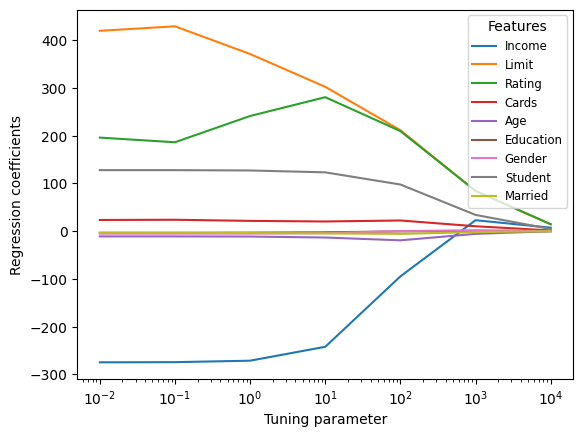

In [7]:
X, y, columns = ridge_regression()
l, b = gradient_descent(X, y)  # use default value for learning rate
plt.xscale("log")
[plt.plot(l, b[i], label=f"{columns[i]}") for i, _ in enumerate(b)]
plt.xlabel("Tuning parameter")
plt.ylabel("Regression coefficients")
plt.legend(title="Features", fontsize="small")
plt.show()